In [11]:
import datetime


In [2]:
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from operator import add

conf = SparkConf().setAppName("demo")
sc = SparkContext(conf=conf)

In [3]:
#load logs into spark
log=sc.textFile("apache-logs/logs")

In [4]:
#parse log returns a dict of

from log_parser import LogRow
lr = LogRow()
plog = log.map(lambda line: LogRow().parseRow(line))
plog.take(5)

[{'date': '25/May/2015:23:11:15 +0000',
  'http': 'GET / HTTP/1.0',
  'ip': '200.4.91.190',
  'os': 'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1)"',
  'response': '200 3557'},
 {'date': '25/May/2015:23:11:15 +0000',
  'http': 'GET / HTTP/1.0',
  'ip': '209.112.63.162',
  'os': 'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; {1C69E7AA-C14E-200E-5A77-8EAB2D667A07})"',
  'response': '200 3557'},
 {'date': '25/May/2015:23:11:15 +0000',
  'http': 'GET / HTTP/1.0',
  'ip': '209.112.9.34',
  'os': 'Mozilla/3.01 (compatible;)"',
  'response': '200 3557'},
 {'date': '25/May/2015:23:11:15 +0000',
  'http': 'GET / HTTP/1.0',
  'ip': '209.112.47.220',
  'os': 'Mozilla/5.0 (Windows; U; Windows NT 5.0; ja-JP; rv:1.7.12) Gecko/20050919 Firefox/1.0.7"',
  'response': '200 3557'},
 {'date': '25/May/2015:23:11:15 +0000',
  'http': 'GET / HTTP/1.0',
  'ip': '200.4.93.122',
  'os': 'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; {1C69E7AA-C14E-200E-5A77-8EAB2D667A07})"',
  'response': '

In [6]:
#parse date and ip tuple

from log_parser import LogRow
logtuple = plog.map(lambda x: (x['date'],x['ip']))
logtuple.take(10)

[('25/May/2015:23:11:15 +0000', '200.4.91.190'),
 ('25/May/2015:23:11:15 +0000', '209.112.63.162'),
 ('25/May/2015:23:11:15 +0000', '209.112.9.34'),
 ('25/May/2015:23:11:15 +0000', '209.112.47.220'),
 ('25/May/2015:23:11:15 +0000', '200.4.93.122'),
 ('25/May/2015:23:11:15 +0000', '155.156.150.253'),
 ('25/May/2015:23:11:15 +0000', '155.157.99.22'),
 ('25/May/2015:23:11:15 +0000', '155.156.103.181'),
 ('25/May/2015:23:11:15 +0000', '155.156.140.104'),
 ('25/May/2015:23:11:15 +0000', '155.157.137.192')]

In [7]:
#create a tuple of datetime
date_tuple = plog.map(lambda x: (x['date'],1))
date_tuple.take(5)

[('25/May/2015:23:11:15 +0000', 1),
 ('25/May/2015:23:11:15 +0000', 1),
 ('25/May/2015:23:11:15 +0000', 1),
 ('25/May/2015:23:11:15 +0000', 1),
 ('25/May/2015:23:11:15 +0000', 1)]

In [8]:
#create a tuple of ip's
ip_tuple = plog.map(lambda x: (x['ip'],1))
ip_tuple.take(5)

[('200.4.91.190', 1),
 ('209.112.63.162', 1),
 ('209.112.9.34', 1),
 ('209.112.47.220', 1),
 ('200.4.93.122', 1)]

In [9]:
#reduce duplicate dates into one entry
date_agg=date_tuple.reduceByKey(add)
date_agg.take(5)

[('25/May/2015:23:11:15 +0000', 1995),
 ('25/May/2015:23:11:17 +0000', 2000),
 ('25/May/2015:23:11:20 +0000', 2000),
 ('25/May/2015:23:11:22 +0000', 1999),
 ('25/May/2015:23:11:24 +0000', 2000)]

In [15]:
from datetime import datetime
#convert date time to python data time object for graphing
datetime_agg = date_agg.map(lambda x: (datetime.strptime(x[0], '%d/%b/%Y:%H:%M:%S +%f'), x[1]))
datetime_agg.take(1)

[(datetime.datetime(2015, 5, 25, 23, 11, 15), 1995)]

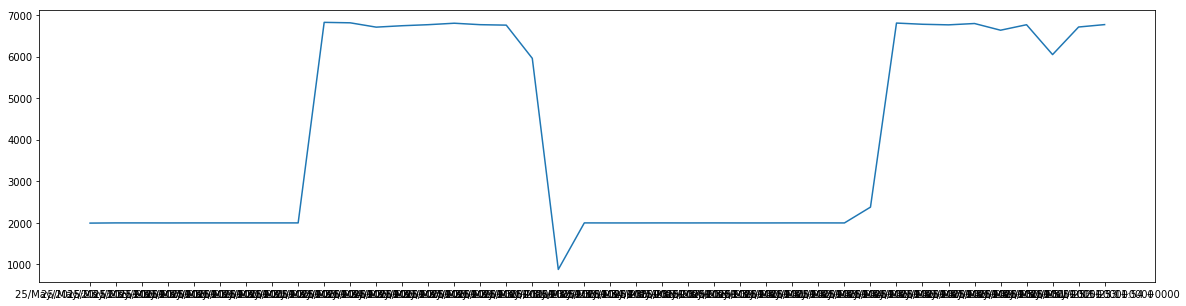

In [67]:
#Look for spikes in traffic
import matplotlib.pyplot as plt

x = date_agg.map(lambda x: x[0]).collect()
x = sorted(x)


y = date_agg.map(lambda x: x[1]).collect()

fig= plt.figure(figsize=(20,5))

plt.plot(x, y)

plt.show()

In [68]:
#tuple for reducing ip hits per date time
date_agg_inv=date_agg.map(lambda x: (x[1],1))
date_agg_inv.take(5)

[(1995, 1), (2000, 1), (2000, 1), (1999, 1), (2000, 1)]

In [71]:
#find mean total number of ip hits for each time stamp
import numpy as np


#reduce
mean=date_agg_inv.map(lambda x: x[0]).mean()


print(mean)
mean = sc.broadcast(mean)


4085.4


In [74]:
#find average number of times ip addresses appear in total sample 

ip_full = plog.map(lambda x: (x['ip'],1)).reduceByKey(add).map(lambda x: x[1])

mean=ip_full.mean()

print(mean)
mean = sc.broadcast(mean)
#sorted(ip_full.take(5), reverse=True)

3.2053037286938837


In [75]:
#find standard deviation of ip hits per datetime
def sd_num(X,Y):
    X= X[0]-Y.value
    X=X*X
    return(X)

sd = date_agg_inv.map(lambda x: x[0]).stdev()
print(sd)
#broadcast sd to all nodes
sd = sc.broadcast(sd)


2356.2279367667297


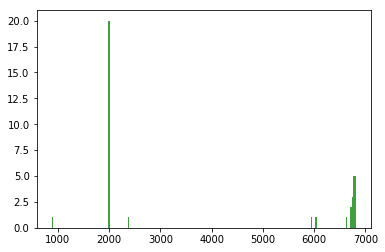

In [76]:
#histogram of distribution of hits per datetime entry
import numpy as np
import matplotlib.pyplot as plt
date_agg.take(5)

x = date_agg.map(lambda x: x[1]).collect()

plt.hist(x, 200, facecolor='g', alpha=.75)

plt.show()


In [77]:
#selects time series that is greater than 2 standard deviations
def sd_select(x, mean, sd):
    diff = x[1] - mean.value 
    if (diff > sd.value*2):
        return(True)
    else:
        return(False)

    
#look for abnormalities in traffic by selecting any traffic spike outside 1 sd to 

date_tuple_select=date_agg.filter(lambda x: (sd_select(x,mean,sd)))
date_tuple_select.collect()

[('25/May/2015:23:11:36 +0000', 6821),
 ('25/May/2015:23:11:38 +0000', 6810),
 ('25/May/2015:23:11:39 +0000', 6706),
 ('25/May/2015:23:11:40 +0000', 6740),
 ('25/May/2015:23:11:41 +0000', 6765),
 ('25/May/2015:23:11:46 +0000', 6800),
 ('25/May/2015:23:11:48 +0000', 6765),
 ('25/May/2015:23:11:51 +0000', 6754),
 ('25/May/2015:23:11:53 +0000', 5956),
 ('25/May/2015:23:11:37 +0000', 6804),
 ('25/May/2015:23:11:42 +0000', 6775),
 ('25/May/2015:23:11:43 +0000', 6761),
 ('25/May/2015:23:11:44 +0000', 6793),
 ('25/May/2015:23:11:45 +0000', 6632),
 ('25/May/2015:23:11:47 +0000', 6764),
 ('25/May/2015:23:11:49 +0000', 6046),
 ('25/May/2015:23:11:50 +0000', 6709),
 ('25/May/2015:23:11:52 +0000', 6767)]

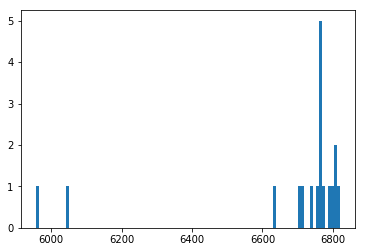

In [78]:
x = date_tuple_select.map(lambda x: x[1]).collect()

plt.hist(x, 100)

plt.show()

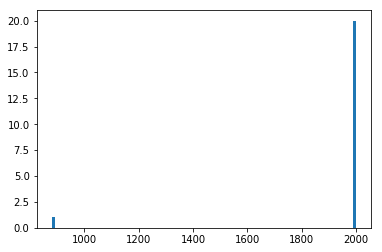

In [79]:
def sd_filter(x, mean, sd):
    diff = x[1] - mean.value 
    if (np.abs(diff) < sd.value*1):
        return(True)
    else:
        return(False)
date_tuple_filter=date_agg.filter(lambda x: (sd_filter(x,mean,sd)))
date_tuple_filter.collect()

x = date_tuple_filter.map(lambda x: x[1]).collect()

plt.hist(x, 100)

plt.show()

In [80]:
#number of times each ip_address apears in results
ip_tuple_agg = ip_tuple.reduceByKey(add).sortBy(lambda x: x[1], False)
ip_tuple_agg.take(10)

[('190.229.54.210', 89),
 ('38.146.252.105', 89),
 ('61.54.183.31', 89),
 ('112.19.126.43', 89),
 ('193.251.94.1', 89),
 ('157.204.221.221', 89),
 ('105.183.142.41', 89),
 ('187.185.215.208', 89),
 ('230.163.105.201', 89),
 ('38.16.230.106', 89)]

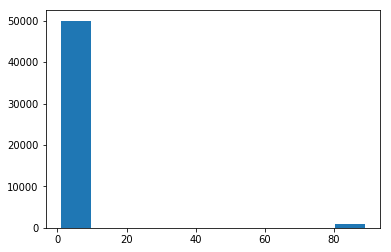

In [81]:
x = ip_tuple_agg.map(lambda x: x[1]).collect()

plt.hist(x)

plt.show()

In [82]:
def avg(X,Y):
    R = 1.0*X[1]/Y[1]
    Ri = 1.0/(1+R);
    av = X[0]*Ri + Y[0]*R*Ri
    return (av, Y[1] + X[1]);

#mean number of times ip's appear in sample data
ip_agg =ip_tuple_agg.map(lambda x: x[1])

#ip_agg.take(5)
mean2=ip_agg.mean()


print(mean2)



3.2053037286938855


In [99]:
# find standard deviation of ip appearences

sd_ = ip_tuple_agg.map(lambda x: x[1])

sd_2 = sd_.stdev()

print(sd_2)
# # ip_sd = sc.broadcast(sd_2)

11.938695643918704


In [160]:
#join suspicious traffice date_time table with ip_table
#date_tuple_select.take(5)
#logtuple.take(5)

#join and create tuple for blacklisted ips
date_black = date_tuple_select.join(logtuple)
ip_black = date_black.map(lambda x: (x[1][1],5))
print('Black Listed IPs')
print(ip_black.take(2))

#merge with ip frequency from main table to make sure we are blocking only repeat offenders
print('Frequency of IPs')
print(ip_tuple_agg.take(2))


ip_black_freq = ip_black.join(ip_tuple_agg)
ip_black_freq = ip_black_freq.distinct()
ip_black_freq = ip_black_freq.map(lambda x: (x[0],x[1][1]))


#filter out IP's that are appearing more than standard deviation of times
tolerance = mean2* sd_2
black_list=ip_black_freq.filter(lambda x: x[1] > tolerance)
black_list.take(10)

#date_black = date_black.filter(lambda x: x[1] > 2 )
#date_black= date_black.sortBy(lambda x: x[1])
#sorted(date_black.take(100), reverse=False)
#analysis of the data shows that IP's either appeared 1 time or 60+ times during the suspected periods

Black Listed IPs
[('87.238.139.236', 5), ('155.156.158.101', 5)]
Frequency of IPs
[('190.229.54.210', 89), ('38.146.252.105', 89)]


[('103.109.231.120', 89),
 ('82.64.188.91', 89),
 ('236.234.66.178', 89),
 ('62.158.60.240', 89),
 ('79.32.35.190', 89),
 ('91.157.33.242', 89),
 ('1.92.109.196', 89),
 ('211.34.172.255', 87),
 ('94.250.131.17', 87),
 ('218.18.59.29', 87)]

In [162]:
def write_ip(x):    
    f=open("lists/black-list.txt", mode="a+", encoding="utf-8")
    f.write(x+"\n")
    f.close
black_ip=black_list.map(lambda x: write_ip(x[0]))
#change to cache()
black_ip.collect()

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [ ]:
#write to hdfa

In [ ]:
ddos = ddos.countByKey()
ddos.collect()

In [ ]:
ddos.collect()